# Capstone Project -  Battle of Neighborhoods

### Importing packages

In [60]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Loading the Toronto data

In [2]:
wiki_url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
from bs4 import BeautifulSoup
import requests
data=requests.get(wiki_url).text 
soup=BeautifulSoup(data, 'html5lib')

In [3]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [4]:
df.shape

(103, 3)

In [5]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [6]:
# Getting the coordinates form the csv file "GeoSpatial Dataset" into a dataframe coord
geo_csv_link='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
coord=pd.read_csv(geo_csv_link)
coord.rename(columns={'Postal Code':'PostalCode'},inplace=True) # Rename for consistency between both tables (for join)
coord.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
# Join the coordinates to the previous neighborhoo DataFrame using the postal codes as keys
toronto_data=df.join(coord.set_index('PostalCode'),on='PostalCode')

In [8]:
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


## Loading the New York data

In [9]:
!wget -q -O 'newyork_data.json' https://raw.githubusercontent.com/TiagoJFreitas/Coursera_Capstone/main/newyork_data.json # Downloaded the newyork_data.json file and uploaded it into GitHub
print('Data downloaded!')

Data downloaded!


In [10]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [11]:
neighborhoods_data = newyork_data['features']

In [12]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
nyc_data = pd.DataFrame(columns=column_names)

In [13]:
for data in neighborhoods_data:
    borough = nyc_name = data['properties']['borough'] 
    nyc_name = data['properties']['name']
        
    nyc_latlon = data['geometry']['coordinates']
    nyc_lat = nyc_latlon[1]
    nyc_lon = nyc_latlon[0]
    
    nyc_data = nyc_data.append({'Borough': borough,
                                          'Neighborhood': nyc_name,
                                          'Latitude': nyc_lat,
                                          'Longitude': nyc_lon}, ignore_index=True)

In [15]:
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Visualizing the data

##### Toronto Data

In [16]:
address_tor = 'Toronto, Canada'

geolocator = Nominatim(user_agent="tor_explorer")
location_tor = geolocator.geocode(address_tor)
latitude_tor = location_tor.latitude
longitude_tor = location_tor.longitude
print('The geographical coordinates of Toronto are {}, {}.'.format(latitude_tor, longitude_tor))

The geographical coordinates of Toronto are 43.6534817, -79.3839347.


In [17]:
# create map of Toronto using latitude and longitude values
map_tor = folium.Map(location=[latitude_tor, longitude_tor], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

#### New York City Data

In [18]:
address_nyc = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location_nyc = geolocator.geocode(address_nyc)
latitude_nyc = location_nyc.latitude
longitude_nyc = location_nyc.longitude
print('The geographical coordinates of New York are {}, {}.'.format(latitude_nyc, longitude_nyc))

The geographical coordinates of New York are 40.7127281, -74.0060152.


In [19]:
# create map of Toronto using latitude and longitude values
map_nyc = folium.Map(location=[latitude_nyc, longitude_nyc], zoom_start=11)

# add markers to map
for lat, lng, label in zip(nyc_data['Latitude'], nyc_data['Longitude'], nyc_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

## Clustering Analysis

In [20]:
CLIENT_ID = 'O05RG4VZAEEEQF5O2KRN2OAQCWNYOOEHE01JIPE4CQUHLTKN' # your Foursquare ID
CLIENT_SECRET = 'WMCMMLUDWTXP25IWKXMP4U1AXR4ZRIY3UEEQNABENPJJNIQK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O05RG4VZAEEEQF5O2KRN2OAQCWNYOOEHE01JIPE4CQUHLTKN
CLIENT_SECRET:WMCMMLUDWTXP25IWKXMP4U1AXR4ZRIY3UEEQNABENPJJNIQK


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Toronto

In [22]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [24]:
toronto_onehot.shape

(2136, 274)

In [25]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000

In [26]:
toronto_grouped.shape

(98, 274)

In [27]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                        venue  freq
0                      Lounge  0.25
1                Skating Rink  0.25
2              Breakfast Spot  0.25
3   Latin American Restaurant  0.25
4                 Yoga Studio  0.00
5          Mexican Restaurant  0.00
6  Modern European Restaurant  0.00
7           Mobile Phone Shop  0.00
8          Miscellaneous Shop  0.00
9   Middle Eastern Restaurant  0.00


----Alderwood, Long Branch----
                             venue  freq
0                      Pizza Place  0.33
1                              Gym  0.17
2                   Sandwich Place  0.17
3                      Coffee Shop  0.17
4                              Pub  0.17
5               Miscellaneous Shop  0.00
6              Monument / Landmark  0.00
7  Molecular Gastronomy Restaurant  0.00
8       Modern European Restaurant  0.00
9                Mobile Phone Shop  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0        

                  venue  freq
0        Clothing Store  0.12
1           Coffee Shop  0.07
2  Fast Food Restaurant  0.06
3            Shoe Store  0.04
4   Japanese Restaurant  0.04
5            Food Court  0.03
6                Bakery  0.03
7                  Bank  0.03
8             Juice Bar  0.03
9     Electronics Store  0.03


----First Canadian Place, Underground city----
                 venue  freq
0          Coffee Shop  0.11
1                 Café  0.07
2                Hotel  0.05
3  Japanese Restaurant  0.04
4                  Gym  0.04
5           Restaurant  0.04
6     Asian Restaurant  0.03
7          Salad Place  0.03
8   Seafood Restaurant  0.03
9               Bakery  0.03


----Forest Hill North & West----
                        venue  freq
0                        Park  0.25
1            Sushi Restaurant  0.25
2               Jewelry Store  0.25
3                       Trail  0.25
4                 Yoga Studio  0.00
5          Mexican Restaurant  0.00
6  Modern Europ

                        venue  freq
0        Fast Food Restaurant  0.33
1                        Park  0.33
2           Food & Drink Shop  0.33
3               Metro Station  0.00
4  Modern European Restaurant  0.00
5           Mobile Phone Shop  0.00
6          Miscellaneous Shop  0.00
7   Middle Eastern Restaurant  0.00
8          Mexican Restaurant  0.00
9    Mediterranean Restaurant  0.00


----Regent Park, Harbourfront----
               venue  freq
0        Coffee Shop  0.17
1               Park  0.07
2                Pub  0.07
3               Café  0.07
4             Bakery  0.07
5            Theater  0.04
6     Breakfast Spot  0.04
7  Health Food Store  0.02
8         Beer Store  0.02
9       Dessert Shop  0.02


----Richmond, Adelaide, King----
             venue  freq
0      Coffee Shop  0.10
1             Café  0.05
2       Restaurant  0.04
3  Thai Restaurant  0.04
4              Gym  0.03
5   Clothing Store  0.03
6    Deli / Bodega  0.03
7   Cosmetics Shop  0.02
8     Conce

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Pub,Sandwich Place,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Fried Chicken Joint,Sandwich Place,Bridal Shop,Diner,Restaurant,Deli / Bodega,Intersection
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Women's Store,Doner Restaurant,Discount Store,Distribution Center,Dog Run,Donut Shop
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Comfort Food Restaurant,Thai Restaurant,Juice Bar,Restaurant,Fast Food Restaurant,Butcher,Pub


In [29]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0], dtype=int32)

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Food & Drink Shop,Park,Fast Food Restaurant,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,2.0,Intersection,French Restaurant,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2.0,Coffee Shop,Park,Bakery,Pub,Café,Breakfast Spot,Theater,Shoe Store,Restaurant,Playground
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2.0,Clothing Store,Accessories Store,Furniture / Home Store,Vietnamese Restaurant,Boutique,Coffee Shop,Event Space,Sporting Goods Shop,Women's Store,Doner Restaurant
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,2.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Spa,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café


In [31]:


# create map
map_clusters_tor = folium.Map(location=[latitude_tor, longitude_tor], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].fillna(kclusters+1)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters_tor)
       
map_clusters_tor

In [65]:
# Cluster 1
cluster1_tor=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster1_tor.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,0.0,Food & Drink Shop,Park,Fast Food Restaurant,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
16,York,0.0,Park,Field,Trail,Hockey Arena,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Department Store
21,York,0.0,Park,Women's Store,Pool,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
40,North York,0.0,Park,Bus Stop,Airport,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
52,North York,0.0,Park,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [66]:
# Cluster 2
cluster2_tor=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster2_tor.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,1.0,Baseball Field,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Farm
101,Etobicoke,1.0,Baseball Field,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Farm


In [67]:
# Cluster 3
cluster3_tor=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster3_tor.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,2.0,Intersection,French Restaurant,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner
2,Downtown Toronto,2.0,Coffee Shop,Park,Bakery,Pub,Café,Breakfast Spot,Theater,Shoe Store,Restaurant,Playground
3,North York,2.0,Clothing Store,Accessories Store,Furniture / Home Store,Vietnamese Restaurant,Boutique,Coffee Shop,Event Space,Sporting Goods Shop,Women's Store,Doner Restaurant
4,Queen's Park,2.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Spa,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café
6,Scarborough,2.0,Fast Food Restaurant,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


In [68]:
# Cluster 4
cluster4_tor=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster4_tor.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Scarborough,3.0,Home Service,Bar,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Women's Store
53,North York,3.0,Home Service,Baseball Field,Food Truck,Dim Sum Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Women's Store
62,Central Toronto,3.0,Garden,Home Service,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Department Store


In [70]:
# Cluster 5
cluster5_tor=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster5_tor.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough,4.0,Grocery Store,Playground,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
46,North York,4.0,Grocery Store,Park,Shopping Mall,Bank,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run


#### New York City

In [37]:
nyc_venues = getNearbyVenues(names=nyc_data['Neighborhood'],
                                   latitudes=nyc_data['Latitude'],
                                   longitudes=nyc_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [38]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle H

In [39]:
nyc_onehot.shape

(10148, 437)

In [40]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle H

In [41]:
nyc_grouped.shape

(302, 437)

In [42]:
num_top_venues = 10

for hood in nyc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                   venue  freq
0            Supermarket  0.10
1            Pizza Place  0.10
2            Bus Station  0.07
3         Discount Store  0.07
4     Chinese Restaurant  0.03
5         Breakfast Spot  0.03
6          Grocery Store  0.03
7            Gas Station  0.03
8                    Spa  0.03
9  Check Cashing Service  0.03


----Annadale----
                  venue  freq
0         Deli / Bodega  0.12
1            Restaurant  0.12
2         Train Station  0.12
3           Pizza Place  0.12
4        Cosmetics Shop  0.12
5                   Pub  0.12
6              Pharmacy  0.12
7                 Diner  0.12
8  Other Great Outdoors  0.00
9                  Park  0.00


----Arden Heights----
              venue  freq
0     Deli / Bodega  0.12
1        Playground  0.12
2          Bus Stop  0.12
3  Business Service  0.12
4          Pharmacy  0.12
5      Home Service  0.12
6       Pizza Place  0.12
7       Coffee Shop  0.12
8        Public Art  0.00
9        

                  venue  freq
0           Gas Station  0.10
1            Donut Shop  0.10
2        Sandwich Place  0.05
3              Bus Stop  0.05
4           Supermarket  0.05
5          Burger Joint  0.05
6  Caribbean Restaurant  0.05
7   Fried Chicken Joint  0.05
8         Grocery Store  0.05
9             Nightclub  0.05


----Bronxdale----
                   venue  freq
0     Chinese Restaurant  0.20
1            Supermarket  0.07
2         Breakfast Spot  0.07
3     Mexican Restaurant  0.07
4  Performing Arts Venue  0.07
5                   Bank  0.07
6                   Park  0.07
7            Pizza Place  0.07
8                    Gym  0.07
9          Grocery Store  0.07


----Brooklyn Heights----
                  venue  freq
0         Deli / Bodega  0.06
1           Yoga Studio  0.04
2  Gym / Fitness Center  0.03
3                 Plaza  0.03
4        Cosmetics Shop  0.03
5           Pizza Place  0.03
6                 Diner  0.03
7    Italian Restaurant  0.03
8           

                          venue  freq
0                Sandwich Place  0.50
1                    Comic Shop  0.25
2                    Playground  0.25
3                   Yoga Studio  0.00
4                      Pet Café  0.00
5  Peruvian Roast Chicken Joint  0.00
6           Peruvian Restaurant  0.00
7            Persian Restaurant  0.00
8         Performing Arts Venue  0.00
9              Pedestrian Plaza  0.00


----Crown Heights----
                venue  freq
0         Pizza Place  0.17
1              Bakery  0.11
2                Café  0.11
3              Museum  0.11
4         Supermarket  0.06
5         Candy Store  0.06
6          Bagel Shop  0.06
7          Playground  0.06
8  Salon / Barbershop  0.06
9        Liquor Store  0.06


----Cypress Hills----
                  venue  freq
0   Fried Chicken Joint  0.09
1  Fast Food Restaurant  0.06
2        Ice Cream Shop  0.06
3    Chinese Restaurant  0.06
4           Supermarket  0.03
5                  Food  0.03
6    Seafood Res

----Fordham----
                  venue  freq
0            Donut Shop  0.06
1  Fast Food Restaurant  0.06
2     Mobile Phone Shop  0.06
3    Spanish Restaurant  0.05
4        Clothing Store  0.05
5            Shoe Store  0.05
6                  Bank  0.05
7              Pharmacy  0.04
8    Chinese Restaurant  0.04
9  Gym / Fitness Center  0.04


----Forest Hills----
                  venue  freq
0  Gym / Fitness Center  0.08
1                   Gym  0.08
2           Yoga Studio  0.05
3       Thai Restaurant  0.05
4           Pizza Place  0.05
5     Convenience Store  0.05
6              Pharmacy  0.05
7                  Park  0.05
8                   Spa  0.02
9            Boxing Gym  0.02


----Forest Hills Gardens----
               venue  freq
0             Bakery  0.10
1      Grocery Store  0.10
2         Bagel Shop  0.05
3               Bank  0.05
4        Pizza Place  0.05
5  Food & Drink Shop  0.05
6     Sandwich Place  0.05
7         Playground  0.05
8              Plaza  0.05




----Hudson Yards----
                  venue  freq
0  Gym / Fitness Center  0.06
1    Italian Restaurant  0.05
2   American Restaurant  0.05
3                 Hotel  0.05
4       Thai Restaurant  0.04
5                  Café  0.04
6           Coffee Shop  0.04
7          Burger Joint  0.03
8                   Gym  0.03
9                  Park  0.03


----Huguenot----
                     venue  freq
0                     Bank  0.18
1            Deli / Bodega  0.09
2         Asian Restaurant  0.09
3  Comfort Food Restaurant  0.09
4               Nail Salon  0.09
5               Donut Shop  0.09
6           Sandwich Place  0.09
7       Italian Restaurant  0.09
8            Event Service  0.09
9           Ice Cream Shop  0.09


----Hunters Point----
                 venue  freq
0                 Café  0.07
1   Italian Restaurant  0.06
2  American Restaurant  0.04
3  Japanese Restaurant  0.04
4          Coffee Shop  0.04
5             Wine Bar  0.03
6        Deli / Bodega  0.03
7        

                          venue  freq
0                 Deli / Bodega  0.33
1                   Supermarket  0.17
2            Athletics & Sports  0.17
3            Italian Restaurant  0.17
4                Ice Cream Shop  0.17
5                      Pet Café  0.00
6  Peruvian Roast Chicken Joint  0.00
7           Peruvian Restaurant  0.00
8            Persian Restaurant  0.00
9         Performing Arts Venue  0.00


----Maspeth----
                venue  freq
0         Pizza Place  0.08
1               Diner  0.08
2  Chinese Restaurant  0.08
3       Deli / Bodega  0.08
4       Grocery Store  0.06
5   Mobile Phone Shop  0.06
6                Bank  0.06
7      Ice Cream Shop  0.03
8          Playground  0.03
9              Bakery  0.03


----Melrose----
                  venue  freq
0           Pizza Place  0.14
1        Discount Store  0.07
2         Grocery Store  0.07
3        Sandwich Place  0.07
4              Pharmacy  0.07
5    Spanish Restaurant  0.03
6  Gym / Fitness Center  0.0

                           venue  freq
0               Sushi Restaurant  0.12
1                    Pizza Place  0.12
2          General Entertainment  0.06
3                       Sake Bar  0.06
4                    Bus Station  0.06
5                   Dessert Shop  0.06
6                      Nightclub  0.06
7                            Gym  0.06
8  Paper / Office Supplies Store  0.06
9                     Bagel Shop  0.06


----Old Town----
                 venue  freq
0   Italian Restaurant  0.22
1         Optical Shop  0.11
2       Mattress Store  0.06
3           Playground  0.06
4             Pharmacy  0.06
5               Bakery  0.06
6  American Restaurant  0.06
7         Liquor Store  0.06
8           Restaurant  0.06
9          Gas Station  0.06


----Olinville----
                  venue  freq
0  Caribbean Restaurant   0.2
1   Fried Chicken Joint   0.1
2    Chinese Restaurant   0.1
3           Pizza Place   0.1
4                  Food   0.1
5     Convenience Store   0.1
6  

                  venue  freq
0           Bus Station  0.18
1                  Park  0.18
2          Home Service  0.09
3                   Gym  0.09
4        Baseball Field  0.09
5                  Bank  0.09
6  Medical Supply Store  0.09
7            Food Truck  0.09
8                 Plaza  0.09
9     Outdoor Sculpture  0.00


----Rochdale----
                             venue  freq
0  Southern / Soul Food Restaurant  0.13
1                         Bus Stop  0.07
2                           Market  0.07
3                   Sandwich Place  0.07
4             Fast Food Restaurant  0.07
5                     Liquor Store  0.07
6                   Breakfast Spot  0.07
7               Chinese Restaurant  0.07
8                      Candy Store  0.07
9                             Bank  0.07


----Rockaway Beach----
                       venue  freq
0                      Beach  0.16
1  Latin American Restaurant  0.06
2             Ice Cream Shop  0.04
3           Arepa Restaurant  0.04


----Sunnyside Gardens----
                venue  freq
0                 Bar  0.07
1       Grocery Store  0.05
2         Pizza Place  0.04
3       Deli / Bodega  0.03
4   Korean Restaurant  0.03
5            Pharmacy  0.03
6  Mexican Restaurant  0.03
7  Turkish Restaurant  0.03
8                Bank  0.03
9         Coffee Shop  0.03


----Sunset Park----
                       venue  freq
0  Latin American Restaurant  0.09
1         Mexican Restaurant  0.09
2                Pizza Place  0.09
3                       Bank  0.09
4                     Bakery  0.09
5        Fried Chicken Joint  0.06
6                        Gym  0.06
7                   Pharmacy  0.06
8          Mobile Phone Shop  0.06
9                Record Shop  0.03


----Sutton Place----
                    venue  freq
0      Italian Restaurant  0.05
1             Pizza Place  0.04
2    Gym / Fitness Center  0.04
3       Indian Restaurant  0.03
4                    Park  0.03
5     American Restaurant  0.03
6           

----Woodlawn----
           venue  freq
0  Deli / Bodega  0.13
1            Pub  0.13
2    Pizza Place  0.09
3     Playground  0.09
4     Food Truck  0.09
5  Grocery Store  0.04
6          Trail  0.04
7           Park  0.04
8            Bar  0.04
9  Train Station  0.04


----Woodrow----
                venue  freq
0           Gift Shop  0.07
1        Liquor Store  0.07
2          Donut Shop  0.07
3         Pizza Place  0.07
4            Pharmacy  0.07
5         Coffee Shop  0.07
6  Chinese Restaurant  0.07
7    Sushi Restaurant  0.07
8       Grocery Store  0.07
9  Miscellaneous Shop  0.07


----Woodside----
                       venue  freq
0              Grocery Store  0.08
1            Thai Restaurant  0.06
2  Latin American Restaurant  0.05
3        Filipino Restaurant  0.05
4                        Bar  0.05
5                     Bakery  0.05
6                        Pub  0.04
7        American Restaurant  0.04
8                 Donut Shop  0.04
9             Ice Cream Shop  0.02


In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_nyc = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_nyc['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted_nyc.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_nyc.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Supermarket,Bus Station,Discount Store,Deli / Bodega,Mexican Restaurant,Chinese Restaurant,Bike Trail,Grocery Store,Fast Food Restaurant
1,Annadale,Pizza Place,Cosmetics Shop,Train Station,Pharmacy,Diner,Restaurant,Pub,Deli / Bodega,Factory,Eye Doctor
2,Arden Heights,Deli / Bodega,Business Service,Coffee Shop,Pharmacy,Home Service,Playground,Pizza Place,Bus Stop,Food Truck,Field
3,Arlington,Furniture / Home Store,Bus Stop,Boat or Ferry,Intersection,Grocery Store,Deli / Bodega,Falafel Restaurant,Farm,Factory,Flower Shop
4,Arrochar,Italian Restaurant,Bus Stop,Pizza Place,Deli / Bodega,Nail Salon,Hotel,Middle Eastern Restaurant,Sandwich Place,Liquor Store,Bagel Shop


In [44]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_nyc = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_nyc.labels_[0:10] 

array([4, 4, 4, 4, 4, 1, 1, 1, 1, 4], dtype=int32)

In [45]:
# add clustering labels
neighborhoods_venues_sorted_nyc.insert(0, 'Cluster Labels', kmeans_nyc.labels_)

nyc_merged = nyc_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted_nyc.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bronx,Co-op City,40.874294,-73.829939,4,Liquor Store,Fast Food Restaurant,Pharmacy,Bagel Shop,Grocery Store,Park,Optical Shop,Pizza Place,Restaurant,Donut Shop
2,Bronx,Eastchester,40.887556,-73.827806,4,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Chinese Restaurant,Bowling Alley,Food & Drink Shop,Convenience Store,Pizza Place,Platform
3,Bronx,Fieldston,40.895437,-73.905643,1,Music Venue,Bus Station,River,Plaza,Yemeni Restaurant,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Bronx,Riverdale,40.890834,-73.912585,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# create map
map_clusters_nyc = folium.Map(location=[latitude_nyc, longitude_nyc], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

nyc_merged['Cluster Labels']=nyc_merged['Cluster Labels'].fillna(kclusters+1)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

## Comparison of a neighborhood in NYC with a neighborhood in Toronto

In [50]:
nyc_merged.iloc[27]

Borough                                       Bronx
Neighborhood                           Clason Point
Latitude                                    40.8066
Longitude                                  -73.8541
Cluster Labels                                    1
1st Most Common Venue                          Park
2nd Most Common Venue     South American Restaurant
3rd Most Common Venue                Scenic Lookout
4th Most Common Venue                      Bus Stop
5th Most Common Venue                 Grocery Store
6th Most Common Venue                          Pool
7th Most Common Venue                 Boat or Ferry
8th Most Common Venue                    Playground
9th Most Common Venue             Convenience Store
10th Most Common Venue          Filipino Restaurant
Name: 27, dtype: object

In [55]:
# Selecting the cluster correspondign to Clason Point
cluster_nyc=nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]].dropna()
cluster_nyc.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Fieldston,Music Venue,Bus Station,River,Plaza,Yemeni Restaurant,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm
12,City Island,Thrift / Vintage Store,Seafood Restaurant,History Museum,Frozen Yogurt Shop,Music Venue,Deli / Bodega,Smoke Shop,Grocery Store,Boat or Ferry,Park
27,Clason Point,Park,South American Restaurant,Scenic Lookout,Bus Stop,Grocery Store,Pool,Boat or Ferry,Playground,Convenience Store,Filipino Restaurant
46,Bay Ridge,Spa,Italian Restaurant,Pizza Place,Greek Restaurant,Bar,Chinese Restaurant,American Restaurant,Bagel Shop,Sushi Restaurant,Café
47,Bensonhurst,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Donut Shop,Pharmacy,Ice Cream Shop,Flower Shop,Grocery Store,Shabu-Shabu Restaurant,Noodle House


Text(0.5, 0, 'Number of Venues')

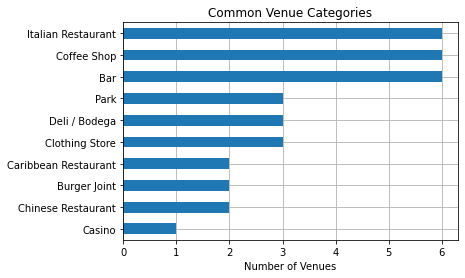

In [74]:
venue1=cluster_nyc['1st Most Common Venue'].value_counts(normalize=False)
ax = venue1.head(10).plot(kind='barh', grid=True);
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.title('Common Venue Categories')
plt.xlabel("Number of Venues")

Text(0.5, 0, 'Number of Venues')

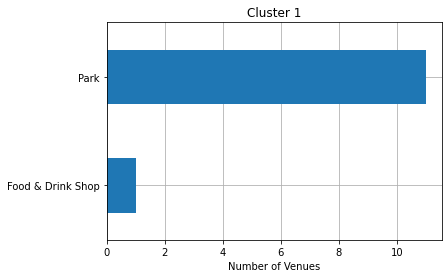

In [75]:
# Toronto's clusters 2, 4 and 5 can be easily excluded just by looking at the tables
# Cluster 1:
venue_cluster1=cluster1_tor['1st Most Common Venue'].value_counts(normalize=False)
ax1=venue_cluster1.head(10).plot(kind='barh', grid=True);
ax1.invert_yaxis()
ax1.set_axisbelow(True)
plt.title('Cluster 1')
plt.xlabel("Number of Venues")

Text(0.5, 0, 'Number of Venues')

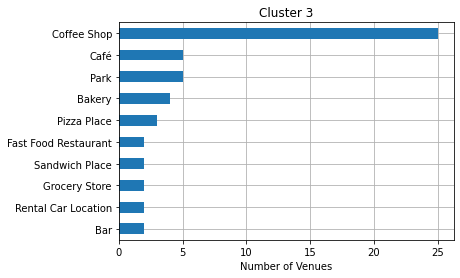

In [77]:
venue_cluster3=cluster3_tor['1st Most Common Venue'].value_counts(normalize=False)
ax3=venue_cluster3.head(10).plot(kind='barh', grid=True);
ax3.invert_yaxis()
ax3.set_axisbelow(True)
plt.title('Cluster 3')
plt.xlabel("Number of Venues")

In [84]:
# Toronto's cluster 3 (index 2) is most similar to NYC's cluster 2 (index 1)
best_cluster=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

In [89]:
# Neighborhood in Toronto's cluster 3:
best_cluster[['Borough','Neighborhood']]

,Borough,Neighborhood
1,North York,Victoria Village
2,Downtown Toronto,"Regent Park, Harbourfront"
3,North York,"Lawrence Manor, Lawrence Heights"
4,Queen's Park,Ontario Provincial Government
6,Scarborough,"Malvern, Rouge"
7,North York,Don Mills North
8,East York,"Parkview Hill, Woodbine Gardens"
9,Downtown Toronto,"Garden District, Ryerson"
10,North York,Glencairn
11,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov..."
